In [2]:
import pandas as pd
import numpy as np
import re
import json
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [ ]:
f = open('tweet_data/tweets_superbowl.txt', "r", encoding = 'utf-8')
wa_pat = re.compile('Washington | WA')
ma_pat = re.compile('Massachusetts | MA')

wa_tweets = []
ma_tweets = []

i = 0
for line in f:
    json_data = json.loads(line)
    if wa_pat.search(json_data['tweet']['user']['location']):
        text = json_data['tweet']['text']
        location = json_data['tweet']['user']['location']
        wa_tweets.append({'text':text, 'location':location})
    elif ma_pat.search(json_data['tweet']['user']['location']):
        text = json_data['tweet']['text']
        location = json_data['tweet']['user']['location']
        ma_tweets.append({'text':text, 'location':location})


In [124]:
f = open('tweet_data/tweets_superbowl.txt', "r", encoding = 'utf-8')
wa_pat = re.compile('\\bWashington\\b | \\bWA\\b')
ma_pat = re.compile('\\bMassachusetts\\b | \\bMA\\b')

wa_tweets = []
ma_tweets = []

i = 0
for line in f:
    json_data = json.loads(line)
    if wa_pat.search(json_data['tweet']['user']['location']):
        text = json_data['tweet']['text']
        location = json_data['tweet']['user']['location']
        wa_tweets.append(json_data)
    elif ma_pat.search(json_data['tweet']['user']['location']):
        text = json_data['tweet']['text']
        location = json_data['tweet']['user']['location']
        ma_tweets.append(json_data)


In [103]:
print('Washington', len(wa_tweets))
print('Masachussets', len(ma_tweets))

('Washington', 13115)
('Masachussets', 12262)


In [126]:
with open("washington.json",'w',encoding="utf-8") as outfile:
    outfile.write(unicode(json.dumps(wa_tweets)))
with open("masachussets.json",'w',encoding="utf-8") as outfile:
    outfile.write(unicode(json.dumps(ma_tweets)))

In [172]:
f1 = open('washington.json', 'r')
f2 = open('masachussets.json', 'r')

en_wa_tweets = []
en_ma_tweets = []

d = json.load(f1)
for i in range(0, len(d)):
        if(d[i]['tweet']['lang'] != 'en'):
            continue
        text = d[i]['tweet']['text']
        location = d[i]['tweet']['user']['location']
        en_wa_tweets.append({'text':text, 'location': location})

d = json.load(f2)
for i in range(0, len(d)):
        if(d[i]['tweet']['lang'] != 'en'):
            continue
        text = d[i]['tweet']['text']
        location = d[i]['tweet']['user']['location']
        en_ma_tweets.append({'text':text, 'location': location})


In [3]:
print('English:', len(en_wa_tweets))
print('English:', len(en_ma_tweets))

('English:', 22581)
('English:', 14413)


In [174]:
with open("en_washington.json",'w',encoding="utf-8") as outfile:
    outfile.write(unicode(json.dumps(en_wa_tweets)))
with open("en_masachussets.json",'w',encoding="utf-8") as outfile:
    outfile.write(unicode(json.dumps(en_ma_tweets)))

In [3]:
en_wa_tweets = json.load(open("en_washington.json",'r'))
en_ma_tweets = json.load(open("en_masachussets.json",'r'))

In [4]:
wa_df = pd.DataFrame(en_wa_tweets)
ma_df = pd.DataFrame(en_ma_tweets)

In [5]:
wa_df['location'] = 0
ma_df['location'] = 1

In [6]:
data = wa_df.append(ma_df)
data = data[['text','location']]

In [7]:
def preprocess_data(data):
        non_url = re.sub(r"http\S+", "", data)
        letters_only = re.sub("[^a-zA-Z]", " ", non_url)
        words = letters_only.split()
        ps = PorterStemmer()
        words = [ps.stem(w).lower() for w in words if not w.lower() in stopwords.words('english')]
        return(" ".join( words ))

In [8]:
n_data = data.as_matrix()

In [9]:
pre_data = np.copy(n_data)
for i in range(0, len(pre_data)):
    pre_data[i, 0] = preprocess_data(pre_data[i, 0])

In [10]:
from  sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(pre_data[:, 0], pre_data[:, 1], test_size=0.20, random_state=42)

In [12]:
vectorizer = CountVectorizer(min_df = 2)
tfidf_transformer = TfidfTransformer()
vec_train_x = vectorizer.fit_transform(X_train)
tfidf_train_x = tfidf_transformer.fit_transform(vec_train_x)
vec_test_x = vectorizer.transform(X_test)
tfidf_test_x = tfidf_transformer.transform(vec_test_x)

In [13]:
svd_model = TruncatedSVD(n_components=50, random_state=0)
train_x = svd_model.fit_transform(tfidf_train_x)
test_x = svd_model.transform(tfidf_test_x)

<h3> SVM Hard Margin Classifier</h3>

In [14]:
classifier_hard = svm.SVC(C=1000, probability=True, kernel='linear')
classifier_hard.fit(train_x, y_train.astype(int))

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
y_predict_hard = classifier_hard.predict(test_x)
y_predict_hard_prob = classifier_hard.predict_proba(test_x)

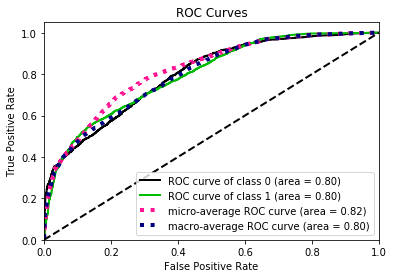

[[4203  287]
 [1695 1214]]
('Accuracy : ', 0.7321259629679686)
('Precision : ', 0.8087941372418388)
('Recall : ', 0.41732554142316947)
              precision    recall  f1-score   support

  Washington       0.71      0.94      0.81      4490
Masachussets       0.81      0.42      0.55      2909

 avg / total       0.75      0.73      0.71      7399



In [16]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_hard_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict_hard))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict_hard))
print("Precision : ",precision_score(y_test.astype(int), y_predict_hard))
print("Recall : ",recall_score(y_test.astype(int), y_predict_hard))

print(classification_report(y_test.astype(int), y_predict_hard, target_names=['Washington', 'Masachussets']))

<h3> SVM Soft Margin Classifier</h3>

In [17]:
classifier_soft = svm.SVC(C=0.001, probability=True, kernel='linear')
classifier_soft.fit(train_x, y_train.astype(int))

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
y_predict_soft = classifier_soft.predict(test_x)
y_predict_soft_prob = classifier_soft.predict_proba(test_x)

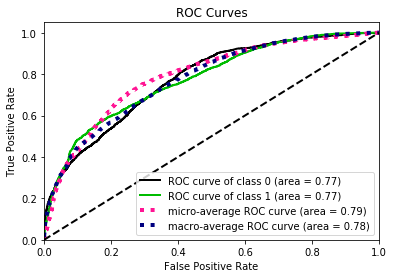

[[4490    0]
 [2909    0]]
('Accuracy : ', 0.6068387619948642)
('Precision : ', 0.0)
('Recall : ', 0.0)
              precision    recall  f1-score   support

  Washington       0.61      1.00      0.76      4490
Masachussets       0.00      0.00      0.00      2909

 avg / total       0.37      0.61      0.46      7399



C:\Python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_soft_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict_soft))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict_soft))
print("Precision : ",precision_score(y_test.astype(int), y_predict_soft))
print("Recall : ",recall_score(y_test.astype(int), y_predict_soft))

print(classification_report(y_test.astype(int), y_predict_soft, target_names=['Washington', 'Masachussets']))

<h3> Finding the best value of Gamma</h3>

In [20]:
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid5 = GridSearchCV(svm.SVC(), param_grid=dict(C=gamma_values, kernel=['linear']), cv=5)
grid5.fit(train_x, y_train.astype(int))

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
print(grid5.best_score_)
print(grid5.best_estimator_)

0.739415441797601
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [22]:
y_predict_best5 = grid5.predict(test_x)
print(classification_report(y_test.astype(int), y_predict_best5, target_names=['Washington', 'Masachussets']))
print("Accuracy Score: " + str(accuracy_score(y_test.astype(int), y_predict_best5)))
confusion_matrix(y_test.astype(int), y_predict_best5)

              precision    recall  f1-score   support

  Washington       0.71      0.94      0.81      4490
Masachussets       0.81      0.42      0.55      2909

 avg / total       0.75      0.73      0.71      7399

Accuracy Score: 0.7321259629679686


array([[4203,  287],
       [1695, 1214]], dtype=int64)

<h3>Logistic Regression without regularization</h3>

In [20]:
logistic_clf = LogisticRegression(penalty='l2', C=1e10)
logistic_clf.fit(train_x, y_train.astype(int))
y_predict = logistic_clf.predict(test_x)
y_predict_prob = logistic_clf.predict_proba(test_x)

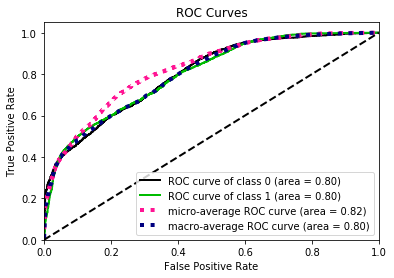

[[4208  282]
 [1640 1269]]
('Accuracy : ', 0.7402351669144479)
('Precision : ', 0.8181818181818182)
('Recall : ', 0.43623238226194566)
              precision    recall  f1-score   support

  Washington       0.72      0.94      0.81      4490
Masachussets       0.82      0.44      0.57      2909

 avg / total       0.76      0.74      0.72      7399



In [21]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachussets']))

<h3>Logistic Regression with L2 regularization</h3>

In [22]:
logistic_clf = LogisticRegression(penalty='l2', C=1000)
logistic_clf.fit(train_x, y_train.astype(int))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
y_predict = logistic_clf.predict(test_x)
y_predict_prob = logistic_clf.predict_proba(test_x)

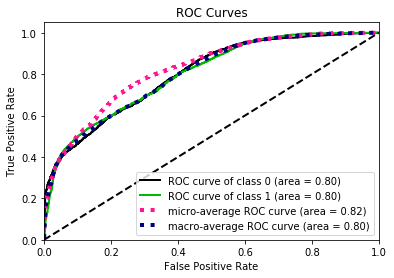

[[4208  282]
 [1640 1269]]
('Accuracy : ', 0.7402351669144479)
('Precision : ', 0.8181818181818182)
('Recall : ', 0.43623238226194566)
              precision    recall  f1-score   support

  Washington       0.72      0.94      0.81      4490
Masachussets       0.82      0.44      0.57      2909

 avg / total       0.76      0.74      0.72      7399



In [24]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachussets']))

<h3>Logistic Regression with L1 regularization</h3>

In [25]:
logistic_clf = LogisticRegression(penalty='l1', C=1000)
logistic_clf.fit(train_x, y_train.astype(int))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
y_predict = logistic_clf.predict(test_x)
y_predict_prob = logistic_clf.predict_proba(test_x)

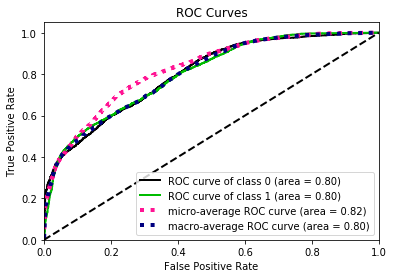

[[4208  282]
 [1640 1269]]
('Accuracy : ', 0.7402351669144479)
('Precision : ', 0.8181818181818182)
('Recall : ', 0.43623238226194566)
              precision    recall  f1-score   support

  Washington       0.72      0.94      0.81      4490
Masachussets       0.82      0.44      0.57      2909

 avg / total       0.76      0.74      0.72      7399



In [27]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachussets']))

<h3>Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rforest_clf = RandomForestClassifier(n_estimators = 150)
rforest_clf.fit(train_x, y_train.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
y_predict = rforest_clf.predict(test_x)
y_predict_prob = rforest_clf.predict_proba(test_x)

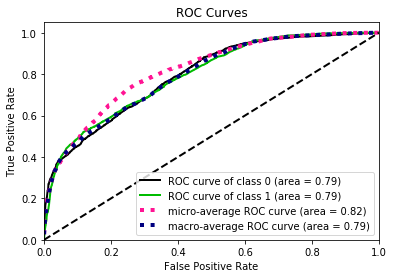

[[4001  489]
 [1444 1465]]
('Accuracy : ', 0.73874847952426)
('Precision : ', 0.7497441146366428)
('Recall : ', 0.5036094877964936)
              precision    recall  f1-score   support

  Washington       0.73      0.89      0.81      4490
Masachussets       0.75      0.50      0.60      2909

 avg / total       0.74      0.74      0.73      7399



In [31]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachussets']))